In [28]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import animation
#plt.style.use(r'PaperDoubleFig.mplstyle')
plt.rcParams["animation.html"] = "html5"
from genesis import Genesis
import os
genesis_bin = os.popen('which genesis2-mpi').read().rstrip()
workdir = os.getcwd()+'/spectrum'
if os.path.isdir(workdir)==False:
    os.mkdir(workdir)

In [52]:
h = 4.135667696e-15 # plank constant [eV.s]
c = 299792458. # [m]

In [53]:
genesis_out_fileName = "data_marie/marieEC.h5"
gen = Genesis('template.in', genesis_bin=genesis_bin)
gen.load_archive(genesis_out_fileName)
data = gen.output["data"]

# original
genff = Genesis("template.in", genesis_bin=genesis_bin)
genff.load_archive("test_ffspec1.h5")
print(gen.output["data"]["dfl"].shape)
print(genff.output["data"]["dfl"].shape)
print(data.keys())

(151, 151, 1088)
(151, 151, 1264)
dict_keys(['aw', 'bunching', 'current', 'dfl', 'dpa', 'energy', 'error', 'increment', 'index', 'p_mid', 'phi_mid', 'power', 'qfld', 'r_size', 'xrms', 'yrms', 'z'])


In [54]:
for key in gen.param.keys():
    if gen[key]!=genff[key]:
        print(f"{key:10s}: {gen[key]}, {genff[key]}")

In [55]:
# print basic info of our slides
print("Array shapes:")
print(f"dfl  : {data['dfl'].shape}")
print(f"z    : {data['z'].shape}")
print(f"dpa  : {data['dpa'].shape}")
print(f"p_mid: {data['p_mid'].shape}")
print(f"An example of the dfl element: {data['dfl'][0,0,-1]:.2f}")
print("")

# Assign variable
dgrid = gen['dgrid']
zsep = gen['zsep']
xlamds = gen['xlamds']
step_size_rad = zsep * xlamds # radiation step size
nslice_rad = data['dfl'].shape[2]
nslice = data['z'].shape[-1]
totalL_rad = (nslice_rad-1)*step_size_rad
ncar = gen['ncar']
dx_dfl = dy_dfl = 2*dgrid / (ncar-1)

# Transverse settings for dfl
print("Transverse bins of dfl (first two indices)")
print(f"Range = [-dgrid, dgrid] = [{-dgrid}, {dgrid}] [m]")
print(f"N points = ncar = {ncar}")
print(f"step size = {dx_dfl:.2e}")
print("")

# logitudinal settings for dfl
print(f"slice size = {step_size_rad:.2e} [m] for the z step size of dfl")


Array shapes:
dfl  : (151, 151, 1088)
z    : (837,)
dpa  : (880, 6, 16384)
p_mid: (880, 837)
An example of the dfl element: -0.00-0.00j

Transverse bins of dfl (first two indices)
Range = [-dgrid, dgrid] = [-0.0001, 0.0001] [m]
N points = ncar = 151
step size = 1.33e-06

slice size = 5.88e-10 [m] for the z step size of dfl


## Transverse Intensities at Various (Radiation) Slice

<IPython.core.display.Javascript object>


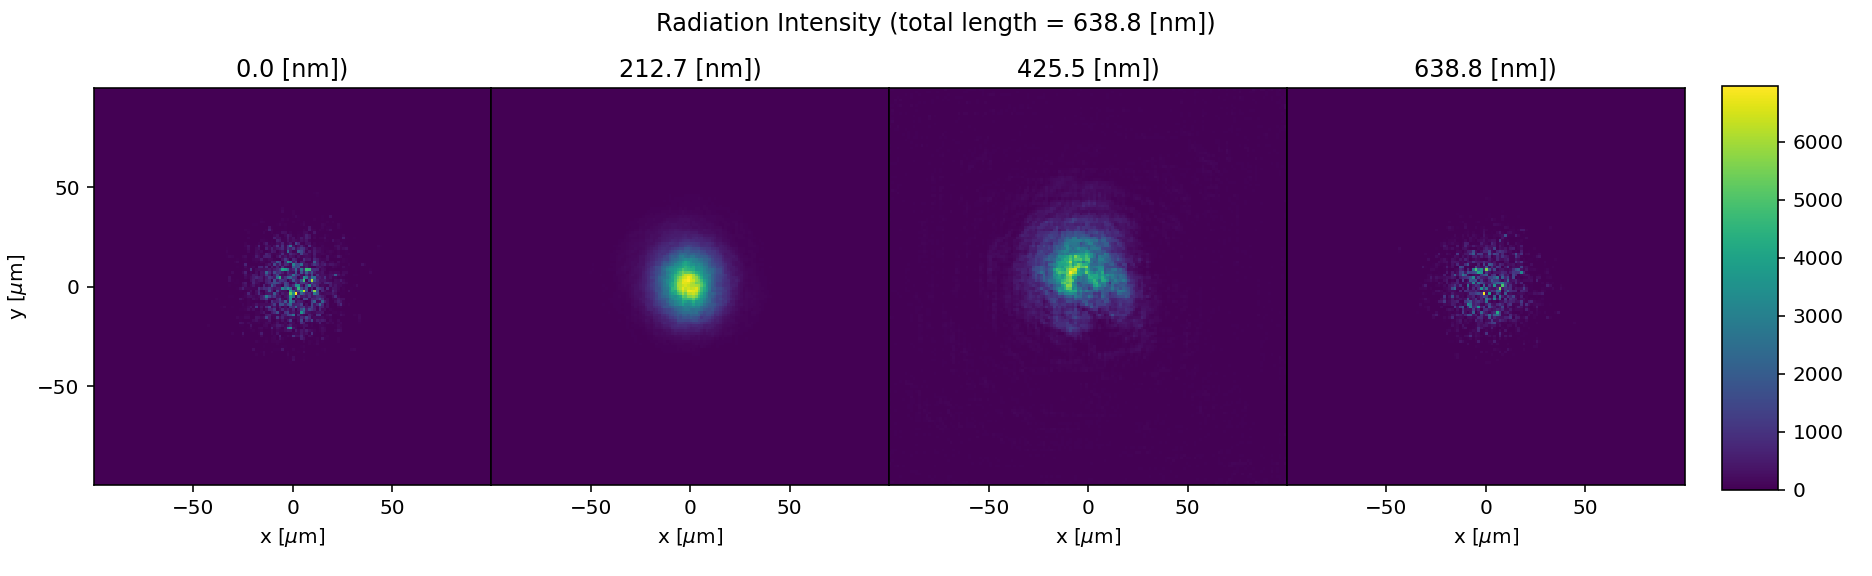

/Users/enchuan/opt/anaconda3/envs/lume/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


In [56]:
### Transverse intensity plot ###
# setup axis
islices = [0,nslice_rad//3, nslice_rad//3*2, nslice_rad-1]
pos_slices = [islice*step_size_rad for islice in islices]
fig, axes  = plt.subplots(1,len(islices), figsize = (13,4))
trans_axis = (-dgrid + dx_dfl * np.arange(ncar))*1e6

# plot each axis
for islice, ax, pos_slice in zip(islices, axes, pos_slices):
    im = ax.pcolor(trans_axis, trans_axis, np.power(np.abs(data["dfl"][:,:,islice]),2))
    ax.set_xlabel(r"x [$\mu$m]")
    ax.get_yaxis().set_visible(False)
    ax.set_xticks([-50,0,50])
    #ax.set_ylabel(r"y [$\mu$m]")
    ax.set_title(f"{pos_slice*1e9:.1f} [nm])")
    ax.set_aspect('equal')

# fig settings
axes[0].get_yaxis().set_visible(True)
axes[0].set_ylabel(r"y [$\mu$m]")
axes[0].set_yticks([-50,0,50])
fig.subplots_adjust(right=0.9, left=0.05)
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.subplots_adjust(wspace=0)
fig.suptitle(f"Radiation Intensity (total length = {totalL_rad*1e9:.1f} [nm])")
fig.show()


## Logitudial E Field Value at Various Transverse Locations

<IPython.core.display.Javascript object>


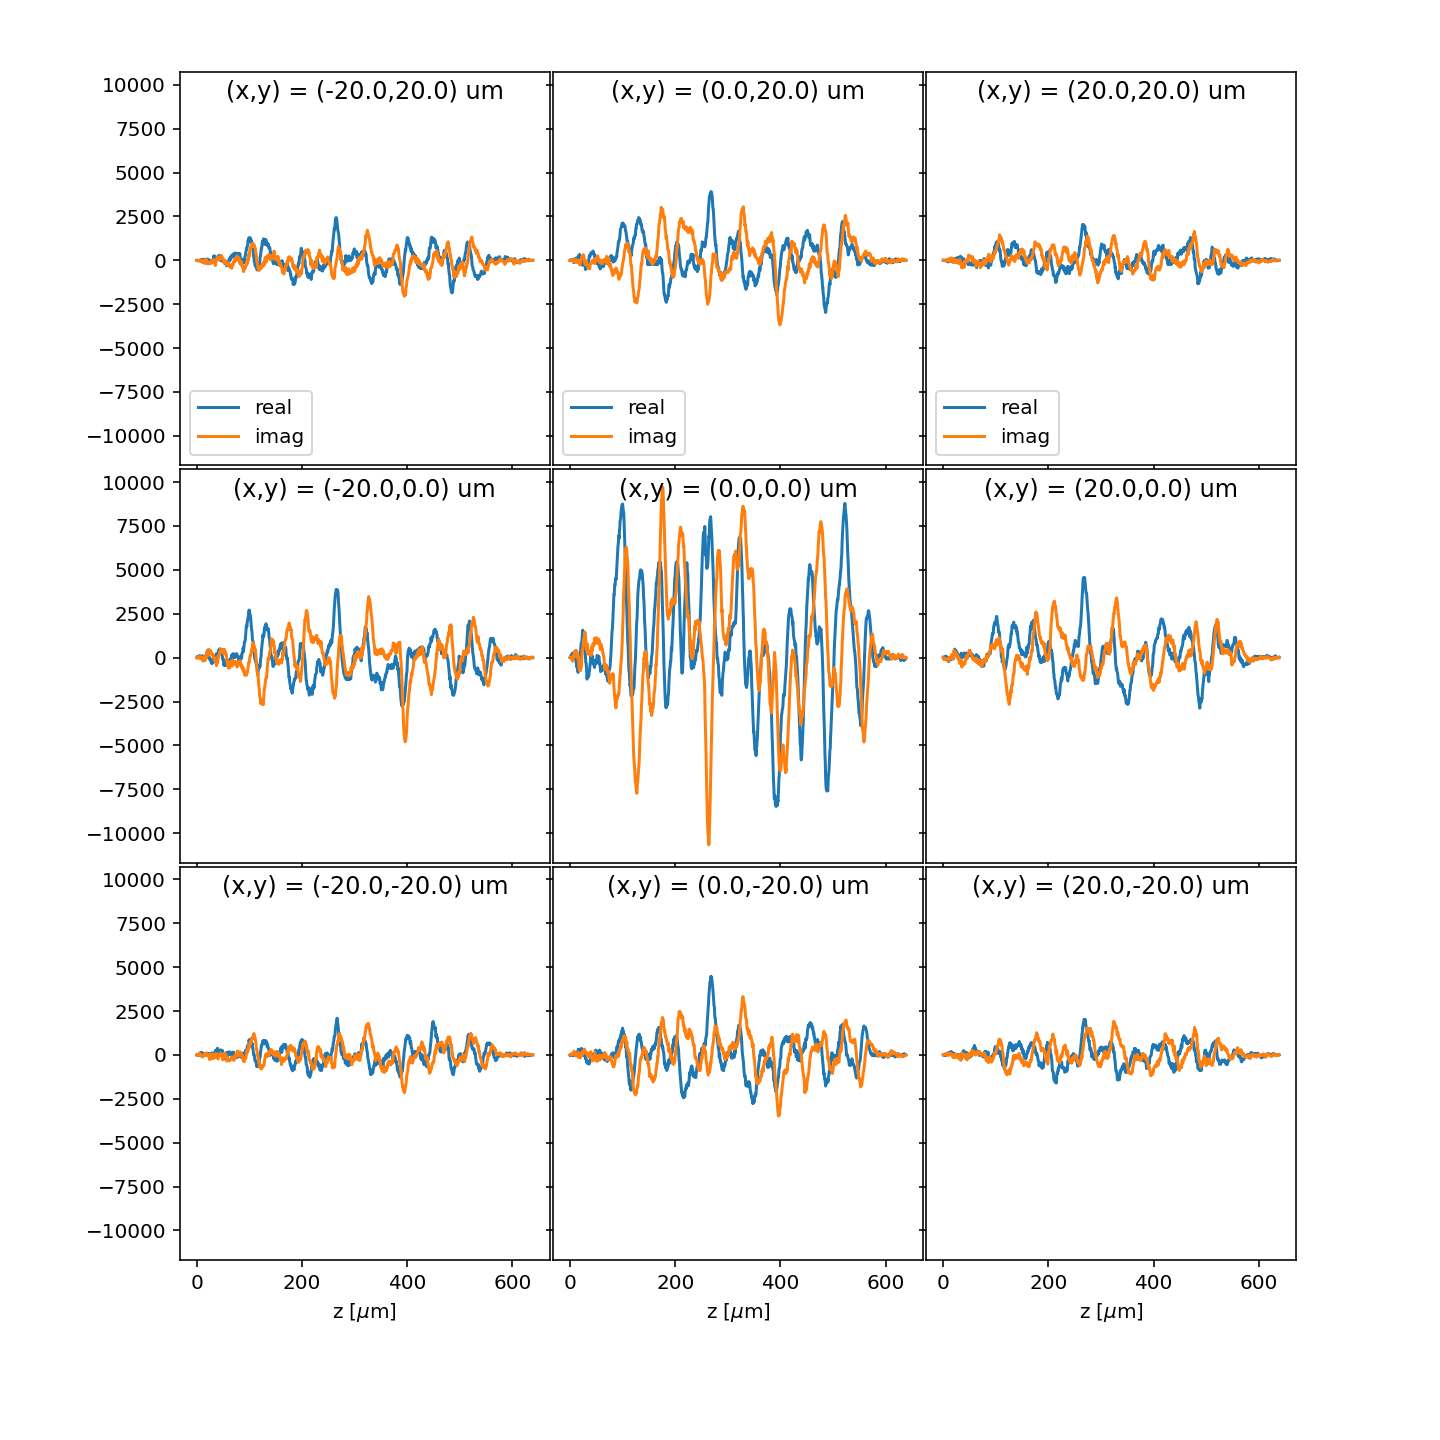

In [57]:
fig, axes = plt.subplots(3,3, figsize=(10,10), sharex=True, sharey=True)
ibin_rad_center = ncar // 2
nbins_rad_rms    = 15
trans_axis
rad_zs = np.arange(nslice_rad) * step_size_rad
for iX in range(3):
    for iY in range(3):
        ibinX = ibin_rad_center + (iX-1)*nbins_rad_rms
        ibinY = ibin_rad_center + (1-iY)*nbins_rad_rms
        posX = trans_axis[ibinX]
        posY = trans_axis[ibinY]
        axes[iY][iX].plot(rad_zs*1e9, data["dfl"][ibinX, ibinY, :].real, label="real")
        axes[iY][iX].plot(rad_zs*1e9, data["dfl"][ibinX, ibinY, :].imag, label="imag")
        axes[iY][iX].set_title(f"(x,y) = ({posX:.1f},{posY:.1f}) um", y=0.9)
    axes[2][iX].set_xlabel(r"z [$\mu$m]")
    axes[0][iX].legend(loc=3)
fig.subplots_adjust(hspace=0.01, wspace=0.01, top=0.95)


# FFT Part
## FFT Demonstration on Toy Model
We created a sinusoidal waveform, did a FFT, then a inverse FFT to obtained a second waveform. We compared the original waveform and the recovered one.

<IPython.core.display.Javascript object>


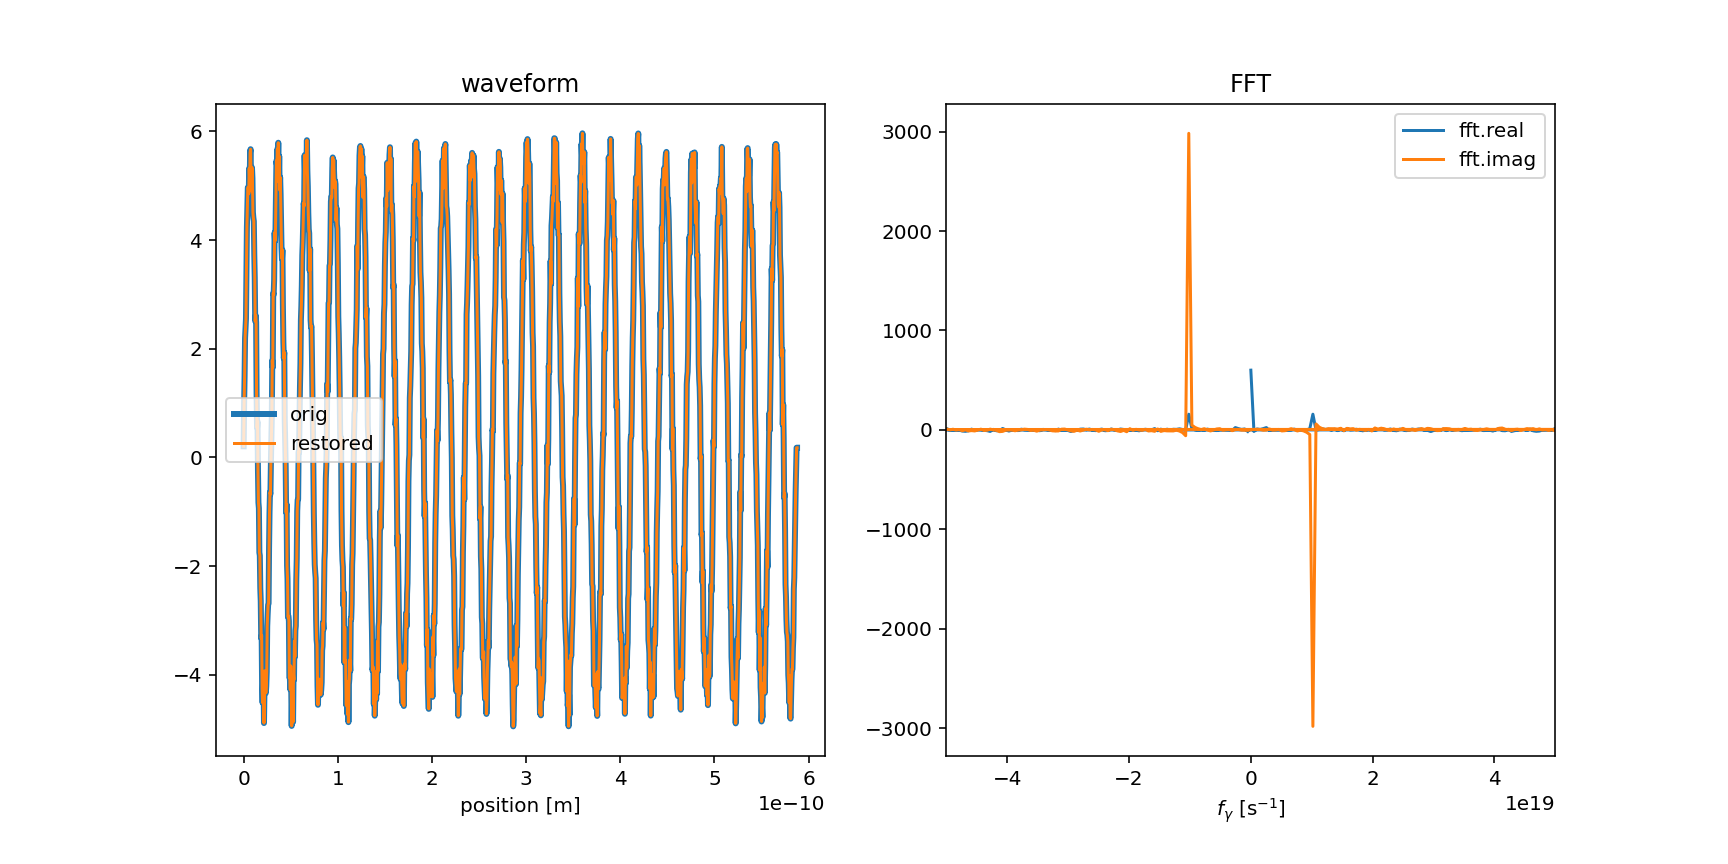

freq_fft = 0.00e+00, freq0 = 1.02e+19
(1200,)


/Users/enchuan/opt/anaconda3/envs/lume/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [58]:
# FFT practice
k = 2*np.pi/xlamds
f0 = c/xlamds
zs = np.linspace(0, 20*xlamds, 1200)
y = np.sin(k*zs)*5 + np.random.random(1200)
#y[:100] = 0
#y[-100:] = 0
sp = np.fft.fft(y)
freq = np.fft.fftfreq(zs.shape[-1], zs[1]-zs[0]) * c
fil_sp = np.array(sp) # filtered spectra
#fil_sp[np.abs(fil_sp.imag)<10] = 0+0j
y2 = np.fft.ifft(fil_sp)
fig, axes = plt.subplots(1,2, figsize=(12,6))

# plot original
axes[0].plot(zs, y, lw=3, label="orig")
axes[1].plot(freq, sp.real, label = "fft.real")
axes[1].plot(freq, sp.imag, label = "fft.imag")

# plot restored
axes[0].plot(zs, y2, label="restored")

# settings
axes[1].set_xlim([-5e19, 5e19])
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("position [m]")
axes[1].set_xlabel(r"$f_\gamma$ [s$^{-1}$]")
axes[0].set_title("waveform")
axes[1].set_title("FFT")
#axes[2].set_title("frequency array")

# print results
freq_fft = np.abs(freq[np.argmax(np.abs(sp.real))]) 
print(f"freq_fft = {freq_fft:.2e}, freq0 = {f0:.2e}")
print(y2.shape)
fig.show()

## FFT the On-Axis Array

<IPython.core.display.Javascript object>


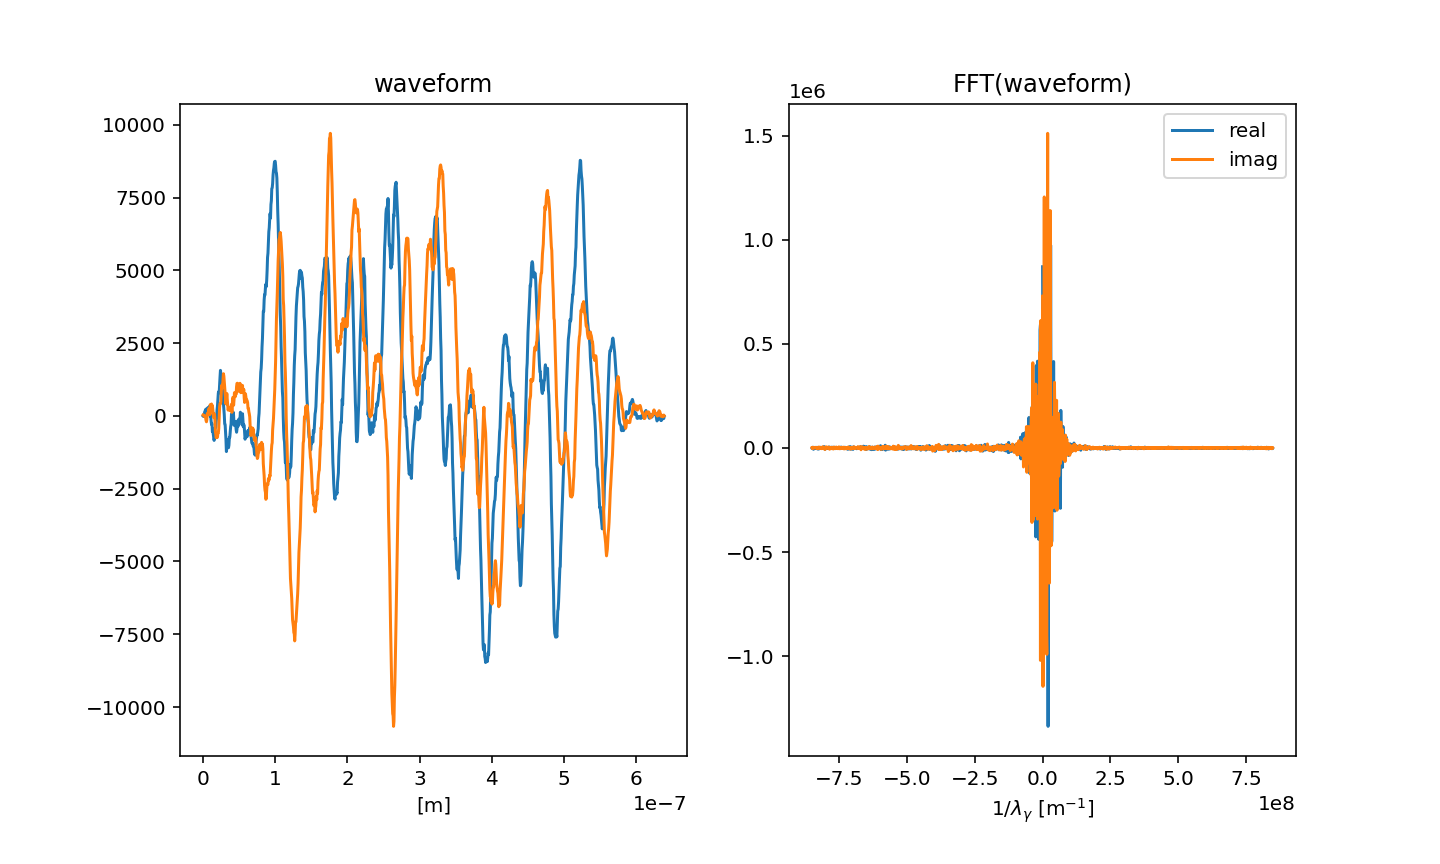

Text(0.5, 0, '$1/\\lambda_\\gamma$ [m$^{-1}$]')

In [59]:
# Choosing the 
iXC = iYC = ncar//2 # center bin
E = data["dfl"][iXC,iYC,:]
Eabs = np.abs(E)
Ephi = np.angle(E)
rad_zs = np.arange(nslice_rad) * step_size_rad
sp = np.fft.fft(E)
lambdaInv = np.fft.fftfreq(E.shape[-1], step_size_rad)  # freq = 1/lambda
_msort = np.argsort(lambdaInv) # to sort lambdaInv so that it looks better
xDeltafs = c*lambdaInv # frequency difference
xDeltaEs = xDeltafs * h
fig, axes = plt.subplots(1,2, figsize=(10,6))
axes[0].plot(rad_zs, E.real)
axes[0].plot(rad_zs, E.imag)
axes[1].plot(lambdaInv, sp.real, label="real")
axes[1].plot(lambdaInv, sp.imag, label="imag")
axes[1].legend()
axes[0].set_title("waveform")
axes[1].set_title("FFT(waveform)")
axes[0].set_xlabel("[m]")
axes[1].set_xlabel(r"$1/\lambda_\gamma$ [m$^{-1}$]")


## FFT All Transverse Positions

In [60]:
fft_spectra = np.zeros((ncar, ncar, nslice_rad), dtype=np.complex)
intensities = np.zeros((ncar, ncar, nslice_rad), dtype=np.float)
for iX in range(ncar):
    for iY in range(ncar):
        fft_spectra[iX, iY] = np.fft.fft(data["dfl"][iX,iY])
        intensities[iX, iY] = np.power(np.abs(fft_spectra[iX, iY]), 2)

### Energy Spectra

<IPython.core.display.Javascript object>


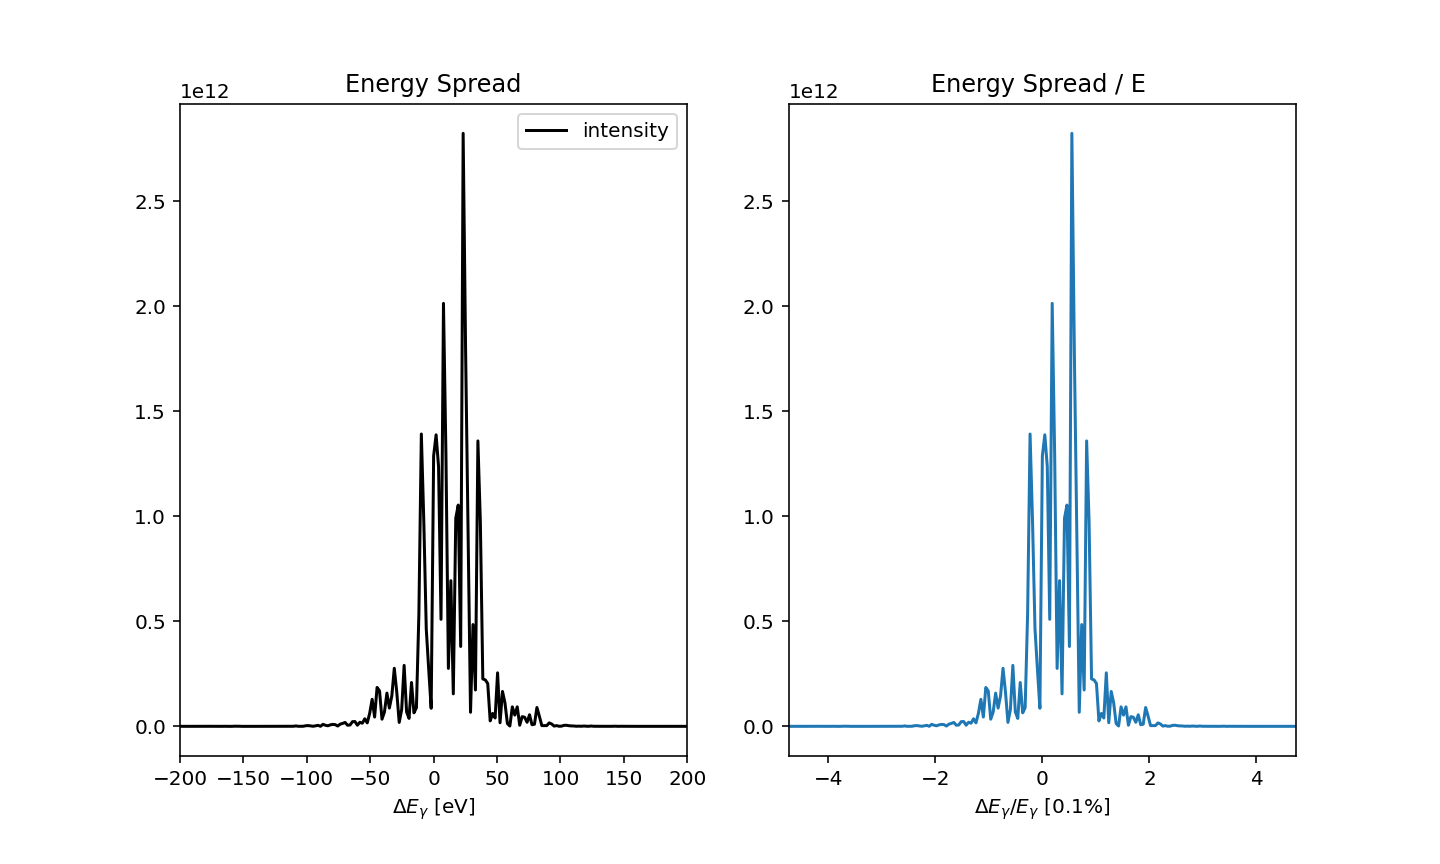

[-4.73995886  4.73995886]


Text(0.5, 1.0, 'Energy Spread / E ')

In [61]:
fig, axes = plt.subplots(1,2, figsize=(10,6))
axes[0].plot(xDeltaEs[_msort], intensities[iXC, iYC][_msort], c="k", label="intensity")
axes[0].set_xlabel(r"$\Delta E_\gamma$ [eV]")
axes[0].legend()
axes[1].plot(xDeltafs[_msort]/f0*1000, intensities[iXC, iYC][_msort])
axes[1].set_xlabel(r"$\Delta E_\gamma/E_\gamma$ [0.1%]")
_xranges = np.array([-200, 200])
print(_xranges/h/f0*1000)
axes[0].set_xlim(_xranges)
axes[1].set_xlim(_xranges/h/f0*1000)
axes[0].set_title("Energy Spread")
axes[1].set_title("Energy Spread / E ")

### Energy Spectra at Various Transverse Locations

<IPython.core.display.Javascript object>


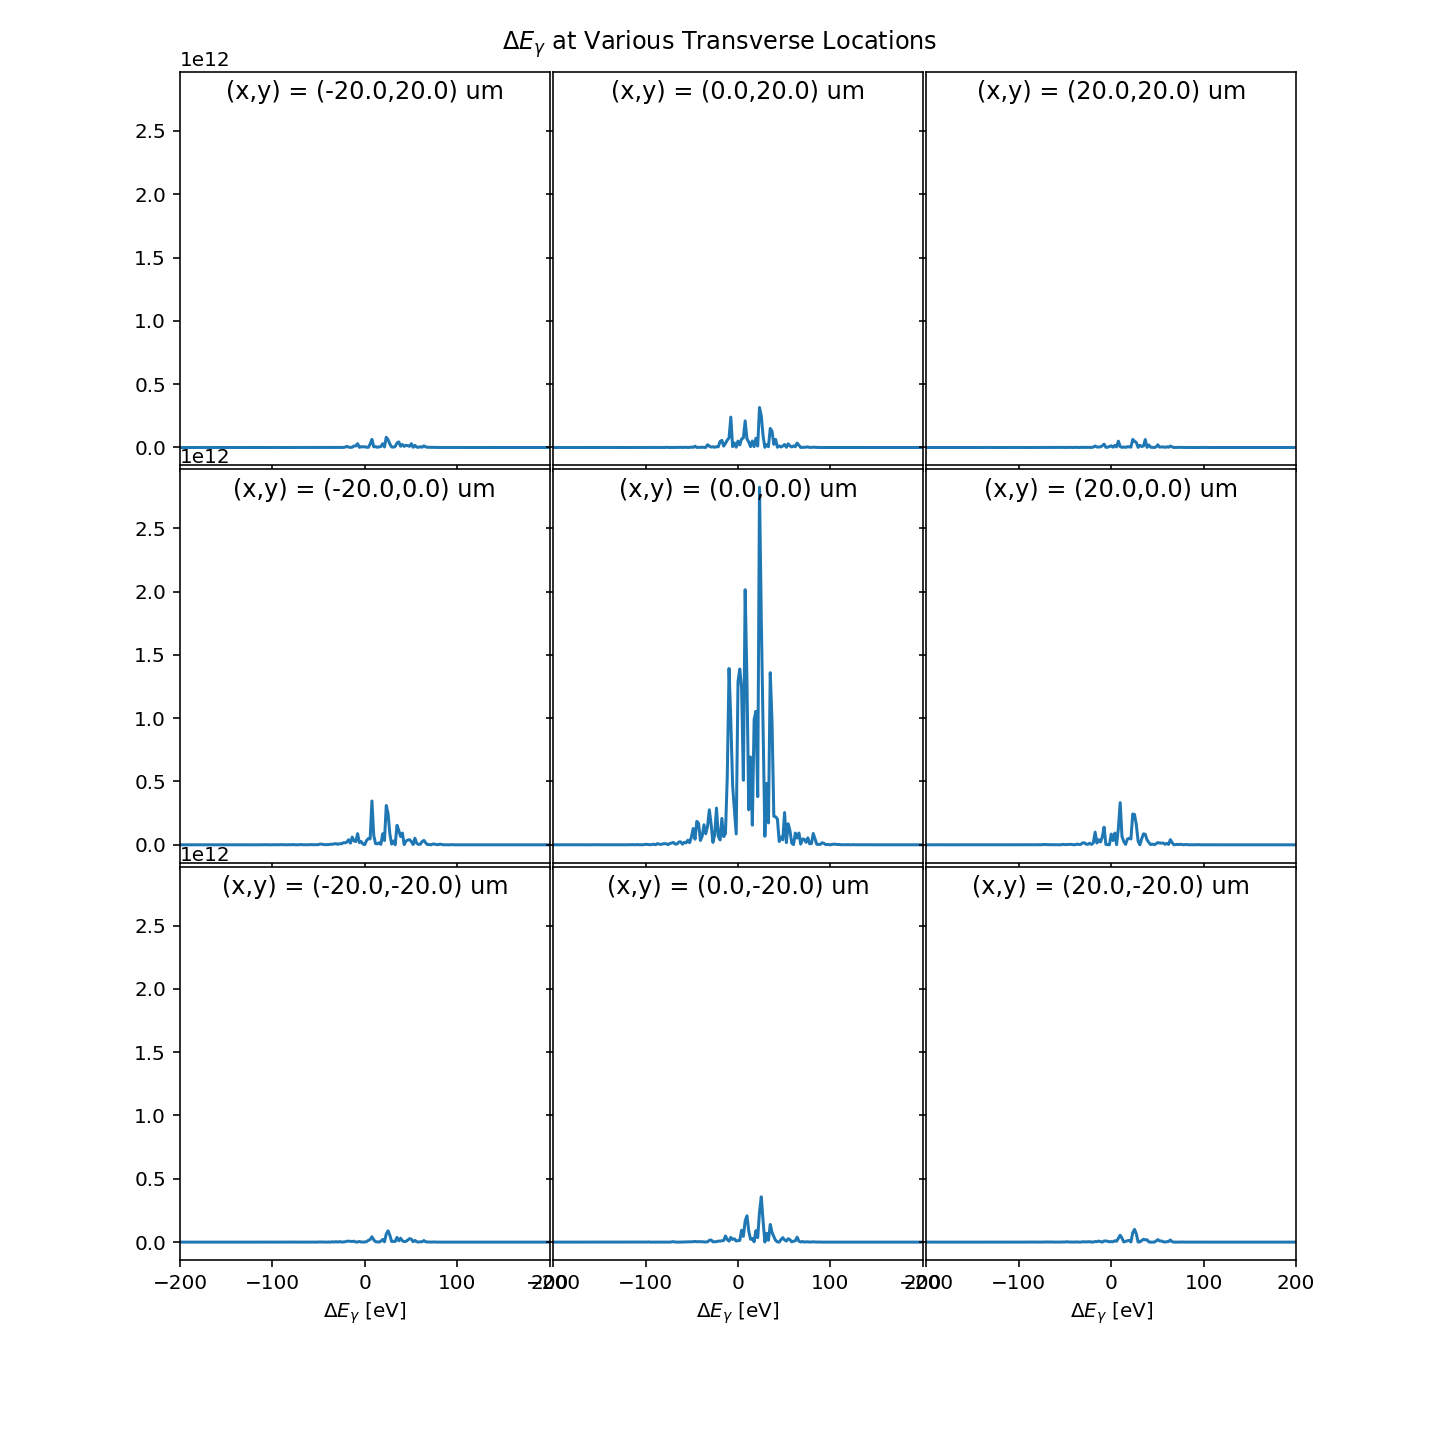

(-200.0, 200.0)

In [62]:
fig, axes = plt.subplots(3,3, figsize=(10,10), sharex=True, sharey=True)

for iX in range(3):
    for iY in range(3):
        ibinX = ibin_rad_center + (iX-1)*nbins_rad_rms
        ibinY = ibin_rad_center + (1-iY)*nbins_rad_rms
        posX = trans_axis[ibinX] # exact location
        posY = trans_axis[ibinY]
        axes[iY][iX].plot(xDeltaEs[_msort], intensities[ibinX, ibinY][_msort])
        axes[iY][iX].set_title(f"(x,y) = ({posX:.1f},{posY:.1f}) um", y=0.9)
    axes[2][iX].set_xlabel(r"$\Delta E_\gamma$ [eV]")
fig.subplots_adjust(hspace=0.01, wspace=0.01, top=0.95)
fig.suptitle(r"$\Delta E_\gamma$ at Various Transverse Locations")
axes[0][0].set_xlim([-200,200])

## Apply Filter
$$
R = \left|-y\pm\sqrt{y^2-1}\right|^2
$$
(Shvyd'ko, X-Ray Optics, Eq. 2.92 (2004)).
We define $y$ as 
$$
y = \frac{\Delta E}{\text{bandWidth}}
$$
and we set band width to 10 eV.


<IPython.core.display.Javascript object>


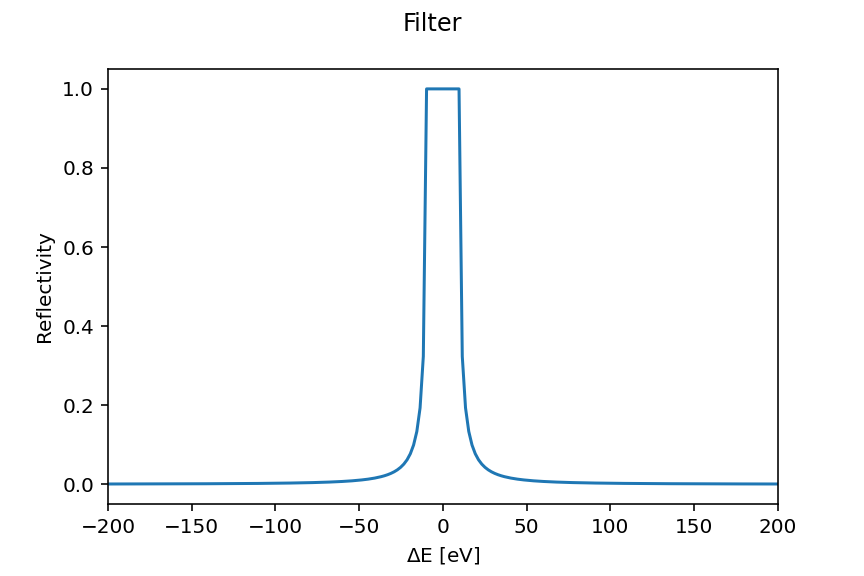

Text(0.5, 0.98, 'Filter')

In [63]:
y = np.array(xDeltaEs / 10, dtype=np.complex) # we want to filter out 10 eV
_signs = np.sign(y.real)
_signs[_signs==0] = 1
Rs = np.power(np.abs(-y+ _signs*np.sqrt(y*y-1)),2)
fig, ax = plt.subplots()
ax.plot(xDeltaEs[_msort], Rs[_msort])
ax.set_xlabel(r"$\Delta$E [eV]")
ax.set_ylabel("Reflectivity")
ax.set_xlim([-200,200])
fig.suptitle("Filter")


In [64]:
# Apply fiter
fil_fft_spectra = np.zeros_like(fft_spectra)
fil_intensities = np.zeros_like(intensities)
fil_dfl = np.zeros_like(data['dfl'])
for iX in range(ncar):
    for iY in range(ncar):
        fil_fft_spectra[iX, iY] = fft_spectra[iX, iY] * Rs
        fil_intensities[iX, iY] = intensities[iX, iY] * Rs
        fil_dfl[iX, iY] = np.fft.ifft(fil_fft_spectra[iX, iY])

<IPython.core.display.Javascript object>


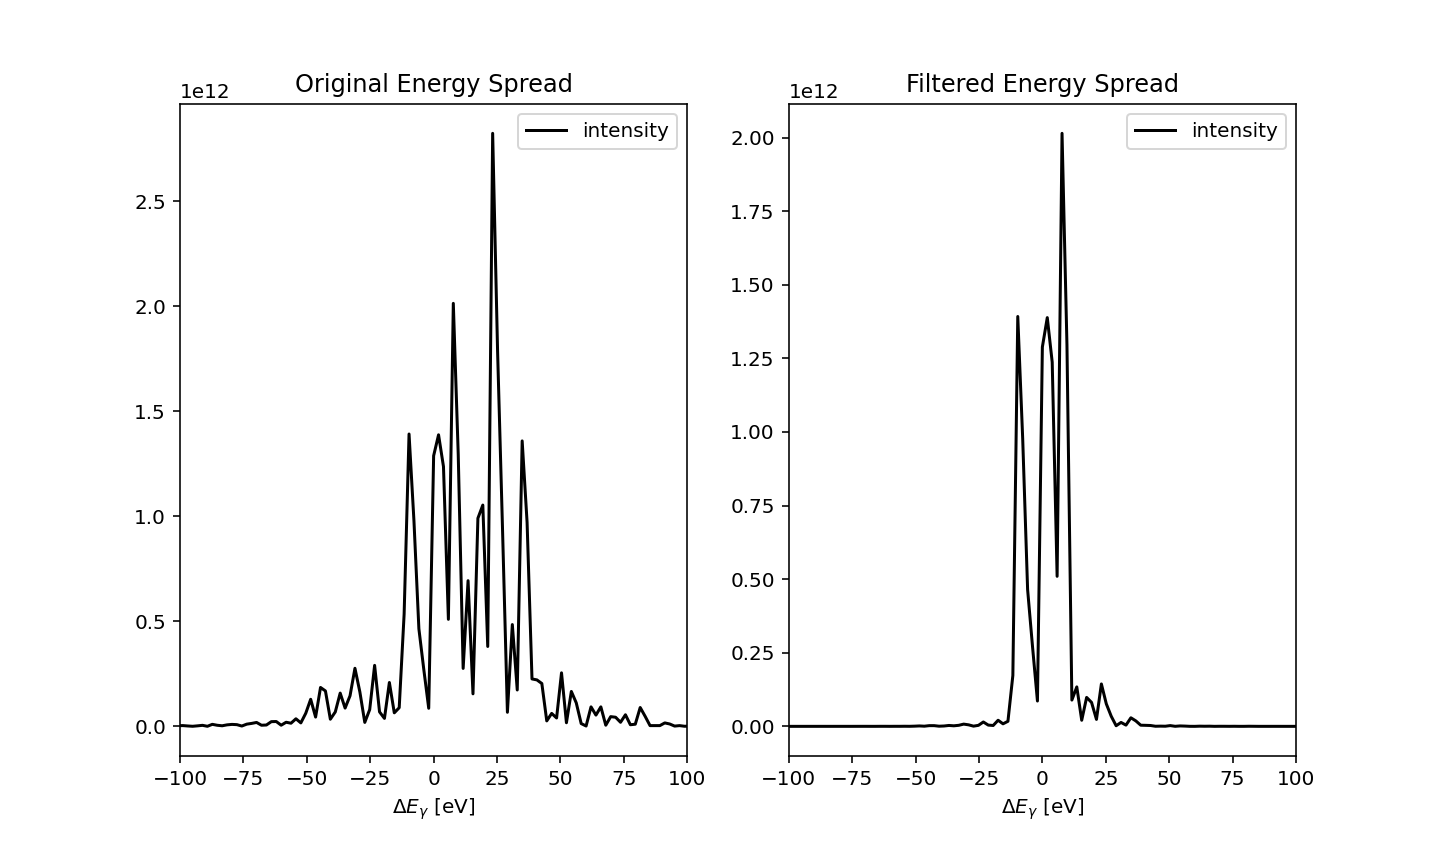

(-100.0, 100.0)

In [65]:
fig, axes = plt.subplots(1,2, figsize=(10,6), sharex=True)
axes[0].plot(xDeltaEs[_msort], intensities[iXC, iYC][_msort], c="k", label="intensity")
axes[0].set_xlabel(r"$\Delta E_\gamma$ [eV]")
axes[0].legend()
axes[1].plot(xDeltaEs[_msort], fil_intensities[iXC, iYC][_msort], c="k", label="intensity")
axes[1].set_xlabel(r"$\Delta E_\gamma$ [eV]")
axes[1].legend()
axes[0].set_title("Original Energy Spread")
axes[1].set_title("Filtered Energy Spread")
axes[1].set_xlim([-100,100])


<IPython.core.display.Javascript object>


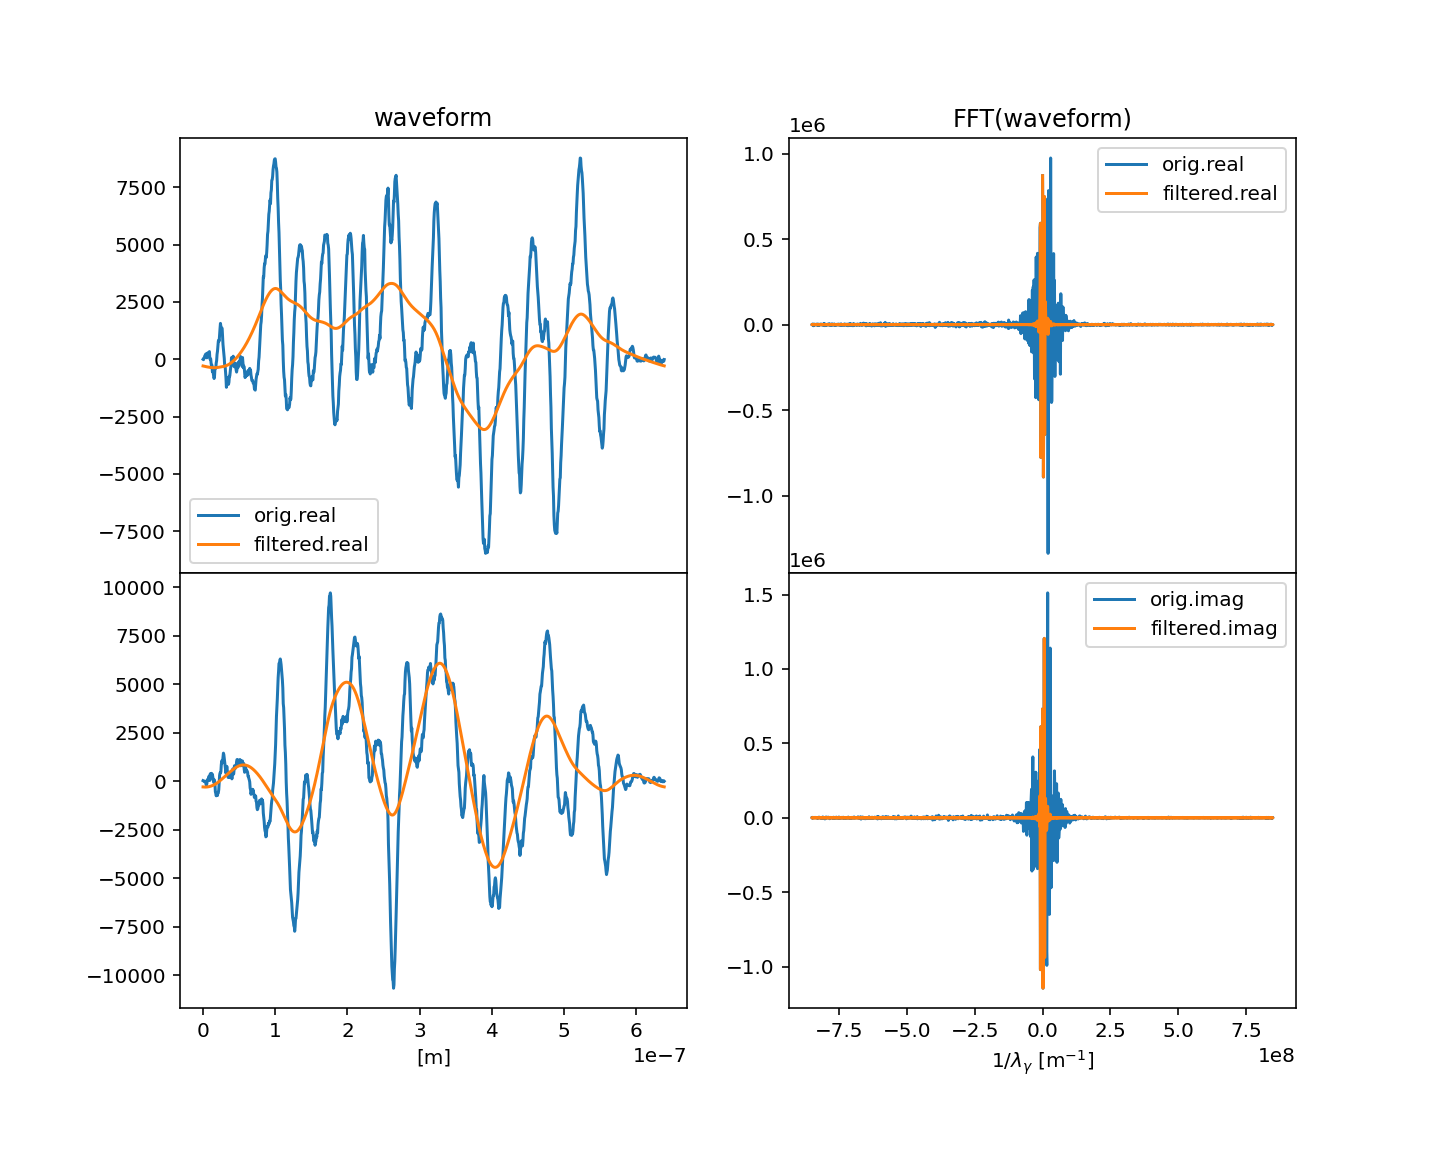

In [66]:
# Choosing the 
iXC = iYC = ncar//2 # center bin
E = data["dfl"][iXC,iYC,:]
E2 = fil_dfl[iXC, iYC, :]
fig, axes = plt.subplots(2,2, figsize=(10,8), sharex="col")
axes[0][0].plot(rad_zs, E.real, label = "orig.real")
axes[0][0].plot(rad_zs, E2.real, label = "filtered.real")
axes[1][0].plot(rad_zs, E.imag, label = "orig.imag")
axes[1][0].plot(rad_zs, E2.imag, label = "filtered.imag")
axes[0][0].legend()
axes[0][0].set_title("waveform")
axes[1][0].set_xlabel("[m]")

sp = fft_spectra[iXC, iYC, :]
sp2 = fil_fft_spectra[iXC, iYC, :]
axes[0][1].plot(lambdaInv, sp.real, label="orig.real")
axes[0][1].plot(lambdaInv, sp2.real, label="filtered.real")
axes[1][1].plot(lambdaInv, sp.imag, label="orig.imag")
axes[1][1].plot(lambdaInv, sp2.imag, label="filtered.imag")
axes[0][1].legend()
axes[1][1].legend()
axes[0][1].set_title("FFT(waveform)")
axes[1][1].set_xlabel(r"$1/\lambda_\gamma$ [m$^{-1}$]")

fig.subplots_adjust(hspace=0)

<IPython.core.display.Javascript object>


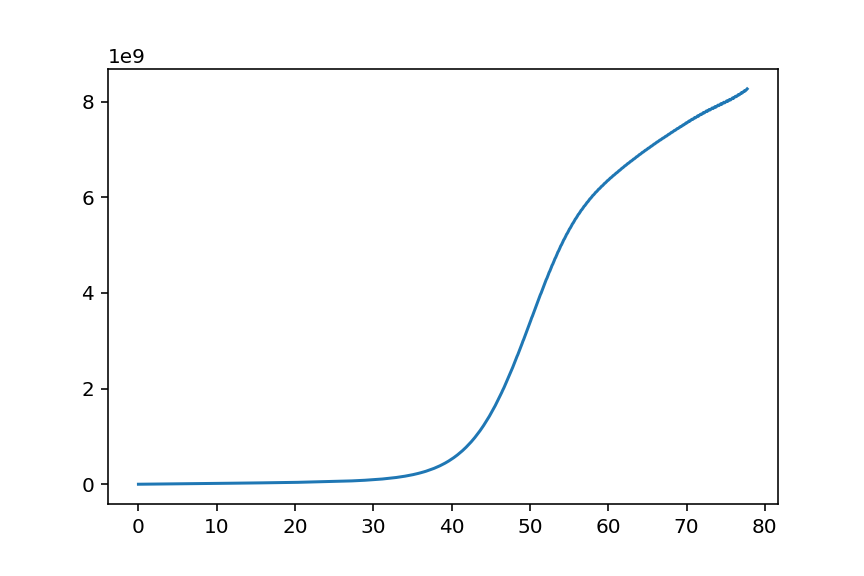

In [67]:
fig, ax = plt.subplots()
ax.plot(data['z'], np.mean(gen.output['data']['power'], axis=0))

<IPython.core.display.Javascript object>


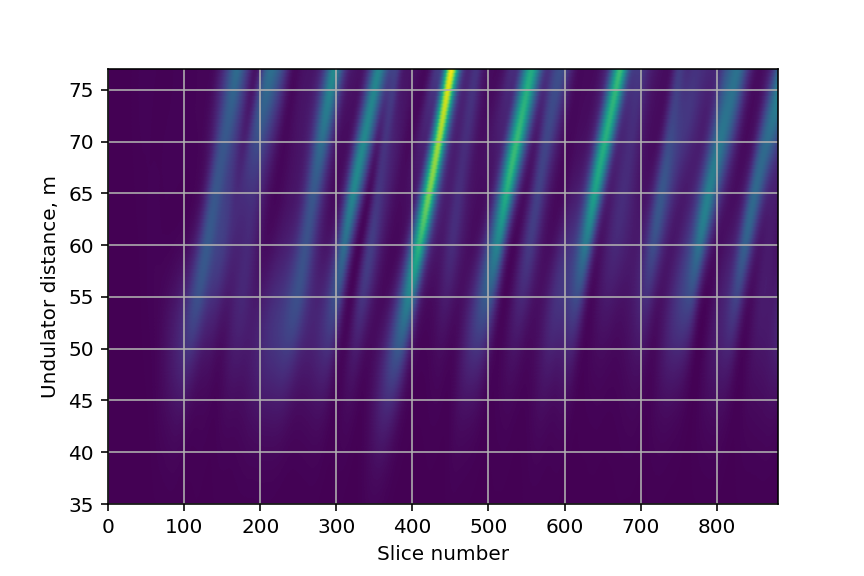

In [68]:
fig, ax = plt.subplots()
plt.imshow(gen.output['data']['power'].T, aspect='auto', origin='lower',
           extent=[0, len(gen.output['data']['power']),
                  gen.output['data']['z'][0], gen.output['data']['z'][-1]])
plt.grid()
plt.xlabel('Slice number')
plt.ylabel('Undulator distance, m')
plt.ylim([35, 77])
plt.show()

<IPython.core.display.Javascript object>


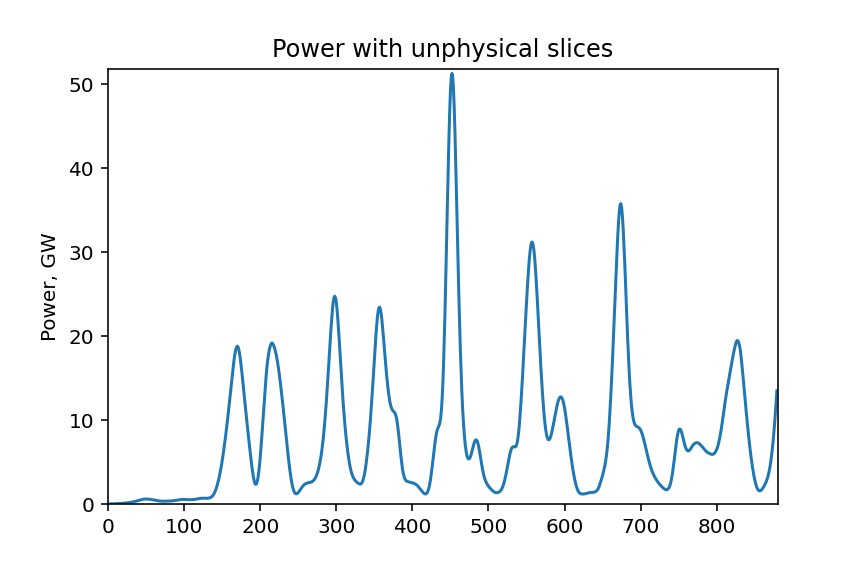

In [69]:
fig, ax = plt.subplots()
ax.plot(1e-9*gen.output['data']['power'][:,-1])
#plt.xlabel('Slice number')
ax.set_ylabel('Power, GW')
ax.set_xlim([0, len(gen.output['data']['power'])])
ax.set_ylim([0, np.max(1e-9*gen.output['data']['power'][:,-1])*1.01])
ax.set_title('Power with unphysical slices')
plt.show()